In [ ]:
import pandas as pd
import json
import zipfile
from collections import Counter
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Load and extract dataset
json_filename = '/content/drive/MyDrive/arxiv-metadata-oai-snapshot.json.zip'
with zipfile.ZipFile(json_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/arxiv_data')

# Path to extracted JSON file
json_filepath = '/content/arxiv_data/arxiv-metadata-oai-snapshot.json'

# Load dataset
ir_data = []
total_papers = 0
cs_ir_papers = 0
json_decode_errors = 0

with open(json_filepath, 'r') as file:
    for line in file:
        try:
            entry_data = json.loads(line)
            total_papers += 1

            if 'cs.IR' in entry_data.get('categories', ''):
                cs_ir_papers += 1
                paper_info = {
                    'id': entry_data.get('id', ''),
                    'title': entry_data.get('title', ''),
                    'authors': entry_data.get('authors', ''),
                    'abstract': entry_data.get('abstract', ''),
                    'category': entry_data.get('categories', ''),
                    'link': f'https://arxiv.org/abs/{entry_data["id"]}'
                }
                ir_data.append(paper_info)
        except json.JSONDecodeError:
            json_decode_errors += 1

df_ir = pd.DataFrame(ir_data)

# Print summary of dataset
print(f"Total number of papers processed: {total_papers}")
print(f"Total number of papers in cs.IR category: {cs_ir_papers}")
print(f"Total number of collected papers: {len(df_ir)}")
print(f"Number of JSON decode errors: {json_decode_errors}")

# Verify that df_ir contains only cs.IR category entries
unique_categories = df_ir['category'].apply(lambda x: 'cs.IR' in x.split()).all()

print(f"All entries in df_ir are in cs.IR category: {unique_categories}")

# Display first few rows of the dataframe
print(df_ir.head(50))


Mounted at /content/drive
Total number of papers processed: 2515829
Total number of papers in cs.IR category: 17357
Total number of collected papers: 17357
Number of JSON decode errors: 0
All entries in df_ir are in cs.IR category: True
           id                                              title  \
0   0704.1158                   Novelty and Collective Attention   
1   0704.1676       Personalizing Image Search Results on Flickr   
2   0704.2902  Recommending Related Papers Based on Digital L...   
3   0704.2963  Using Access Data for Paper Recommendations on...   
4   0704.3316  Vocabulary growth in collaborative tagging sys...   
5   0704.3359            Direct Optimization of Ranking Measures   
6   0704.3635     Rough Sets Computations to Impute Missing Data   
7   0705.0751                      Approximate textual retrieval   
8   0705.1161  IDF revisited: A simple new derivation within ...   
9   0705.1886  Ontology-Supported and Ontology-Driven Concept...   
10  0705.2106  

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer

# Download NLTK data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df_ir['cleaned_abstract'] = df_ir['abstract'].apply(preprocess_text)
print(df_ir['cleaned_abstract'].head())

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize abstracts
tokenized_inputs = df_ir['cleaned_abstract'].apply(lambda x: tokenizer(x, add_special_tokens=True, truncation=True, padding='max_length', max_length=128, return_tensors='pt'))

# Add tokenized inputs to DataFrame
df_ir['input_ids'] = tokenized_inputs.apply(lambda x: x['input_ids'][0].tolist())
df_ir['attention_mask'] = tokenized_inputs.apply(lambda x: x['attention_mask'][0].tolist())

# Prepare labels
mlb = MultiLabelBinarizer()
labels = df_ir['category'].apply(lambda x: x.split()).tolist()
binary_labels = mlb.fit_transform(labels)
df_ir['labels'] = binary_labels.tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    subject collective attention central informati...
1    social media site flickr allows users upload p...
2    important goal digital libraries enable resear...
3    thesis investigates use access log data source...
4    analyze large scale snapshot del icio us inves...
Name: cleaned_abstract, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    df_ir[['input_ids', 'attention_mask']].values.tolist(),
    df_ir['labels'].tolist(),
    test_size=0.2,
    random_state=42
)


In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset

class IRDataset(Dataset):
    def __init__(self, inputs, labels):
        self.input_ids = torch.tensor([input[0] for input in inputs], dtype=torch.long)
        self.attention_masks = torch.tensor([input[1] for input in inputs], dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

train_dataset = IRDataset(train_inputs, train_labels)
val_dataset = IRDataset(val_inputs, val_labels)

batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-6, eps=1e-8)
total_steps = len(train_dataloader) * 4  # 4 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm
import torch

# EarlyStopping class as defined previously
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=3, delta=0.01)

epochs = 10
gradient_accumulation_steps = 2
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model.train()
    total_train_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_dataloader)):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss / gradient_accumulation_steps

        loss.backward()
        total_train_loss += loss.item()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Training loss: {avg_train_loss}')

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f'Validation loss: {avg_val_loss}')

    # Check for early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete!")


Epoch 1/10


100%|██████████| 868/868 [04:31<00:00,  3.19it/s]


Training loss: 0.24913267387841154
Validation loss: 0.37668420161519733
Epoch 2/10


100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.15896962457744207
Validation loss: 0.25905462426524006
Epoch 3/10


100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.11430052201765749
Validation loss: 0.19433088634970003
Epoch 4/10


100%|██████████| 868/868 [04:32<00:00,  3.19it/s]


Training loss: 0.08881177062228802
Validation loss: 0.15662176110502762
Epoch 5/10


100%|██████████| 868/868 [04:32<00:00,  3.19it/s]


Training loss: 0.07368753735439569
Validation loss: 0.1339336696857681
Epoch 6/10


100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.06453726148825087
Validation loss: 0.12032040593124205
Epoch 7/10


100%|██████████| 868/868 [04:32<00:00,  3.19it/s]


Training loss: 0.05918705595167963
Validation loss: 0.11285127431566265
Epoch 8/10


100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.05665807331555999
Validation loss: 0.11038617236960319
Epoch 9/10


100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.05621501624858874
Validation loss: 0.11038617236960319
Early stopping
Training complete!


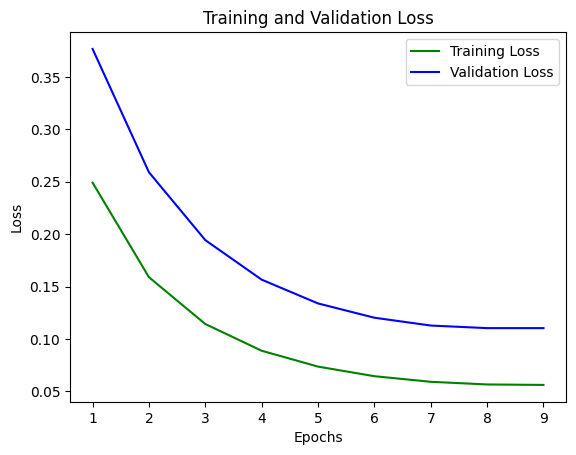

In [ ]:
# prompt: generate the graph for the above result

import matplotlib.pyplot as plt


epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'g', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Split your dataset into training, validation, and test sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    df_ir[['input_ids', 'attention_mask']].values.tolist(),
    df_ir['labels'].tolist(),
    test_size=0.1,
    random_state=42
)

test_dataset = IRDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Evaluate on test set
model.eval()
total_test_loss = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_test_loss += loss.item()

        logits = outputs.logits
        preds = torch.sigmoid(logits).cpu().numpy()
        labels = b_labels.cpu().numpy()

        all_preds.append(preds)
        all_labels.append(labels)

avg_test_loss = total_test_loss / len(test_dataloader)
print(f'Test loss: {avg_test_loss}')


Test loss: 0.11007634413625123


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Flatten predictions and true labels
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Convert probabilities to binary predictions
threshold = 0.5
binary_preds = (all_preds > threshold).astype(int)

print(classification_report(all_labels, binary_preds, target_names=mlb.classes_))


                    precision    recall  f1-score   support

          astro-ph       0.00      0.00      0.00         0
       astro-ph.EP       0.00      0.00      0.00         0
       astro-ph.IM       0.00      0.00      0.00         0
   cond-mat.dis-nn       0.00      0.00      0.00         1
 cond-mat.mtrl-sci       0.00      0.00      0.00         0
    cond-mat.other       0.00      0.00      0.00         0
cond-mat.stat-mech       0.00      0.00      0.00         2
             cs.AI       0.00      0.00      0.00       350
             cs.AR       0.00      0.00      0.00         2
             cs.CC       0.00      0.00      0.00         1
             cs.CE       0.00      0.00      0.00         3
             cs.CG       0.00      0.00      0.00         2
             cs.CL       0.00      0.00      0.00       429
             cs.CR       0.00      0.00      0.00        29
             cs.CV       0.00      0.00      0.00       100
             cs.CY       0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from transformers import TrainingArguments, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import numpy as np

# Define your dataset and other necessary variables here
# ...

param_grid = {
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32]
}

best_val_loss = float('inf')
best_params = {}

for params in ParameterGrid(param_grid):
    # Initialize training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        num_train_epochs=4,
        weight_decay=0.01,
    )

    # Initialize dataloaders
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=params['batch_size'])
    val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=params['batch_size'])

    # Initialize model, optimizer, and scheduler
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))
    optimizer = AdamW(model.parameters(), lr=params['learning_rate'], eps=1e-8)
    total_steps = len(train_dataloader) * training_args.num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Train and evaluate model
    model.train()
    total_train_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_dataloader)):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss / gradient_accumulation_steps
        loss.backward()
        total_train_loss += loss.item()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Training loss: {avg_train_loss}')

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f'Validation loss: {avg_val_loss}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = params

print(f'Best params: {best_params}')


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.08472174869996199
Validation loss: 0.057945419789596636


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.06459076173414695
Validation loss: 0.04840305835557973


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 868/868 [04:32<00:00,  3.18it/s]


Training loss: 0.047534080402505015
Validation loss: 0.04245305081082654


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 434/434 [04:17<00:00,  1.68it/s]


Training loss: 0.1280401587348929
Validation loss: 0.10110300813519627


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 434/434 [04:17<00:00,  1.69it/s]


Training loss: 0.09879921414902271
Validation loss: 0.06789876059244532


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 434/434 [04:17<00:00,  1.69it/s]


Training loss: 0.07137891903416627
Validation loss: 0.04929382637689967
Best params: {'batch_size': 16, 'learning_rate': 5e-05}


In [ ]:
# Save the model
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')

# Load the model
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained('./fine_tuned_model')
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_model')


In [ ]:
import numpy as np

# Analyze misclassified samples
misclassified_indices = np.where((binary_preds != all_labels).any(axis=1))[0]
misclassified_samples = df_ir.iloc[misclassified_indices]

for index, row in misclassified_samples.iterrows():
    print(f"Abstract: {row['abstract']}")
    predicted_labels = mlb.inverse_transform(np.array([binary_preds[index]]))
    actual_labels = mlb.inverse_transform(np.array([all_labels[index]]))
    print(f"Predicted: {predicted_labels}")
    print(f"Actual: {actual_labels}")
    print()


Streaming output truncated to the last 5000 lines.
Actual: [('cs.IR', 'cs.LG')]

Abstract:   We describe methods to predict a crowd worker's accuracy on new tasks based
on his accuracy on past tasks. Such prediction provides a foundation for
identifying the best workers to route work to in order to maximize accuracy on
the new task. Our key insight is to model similarity of past tasks to the
target task such that past task accuracies can be optimally integrated to
predict target task accuracy. We describe two matrix factorization (MF)
approaches from collaborative filtering which not only exploit such task
similarity, but are known to be robust to sparse data. Experiments on synthetic
and real-world datasets provide feasibility assessment and comparative
evaluation of MF approaches vs. two baseline methods. Across a range of data
scales and task similarity conditions, we evaluate: 1) prediction error over
all workers; and 2) how well each method predicts the best workers to use for
eac

In [ ]:
from fastapi import FastAPI, Request
import uvicorn

app = FastAPI()

@app.post("/predict")
async def predict(request: Request):
    data = await request.json()
    inputs = tokenizer(data['text'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = model(**inputs)
    preds = torch.sigmoid(outputs.logits).cpu().numpy()
    binary_preds = (preds > threshold).astype(int)
    labels = mlb.inverse_transform(binary_preds)
    return {"predictions": labels}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)


ModuleNotFoundError: No module named 'fastapi'